In [7]:
import os
import time
from typing import List, Tuple
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import ndimage
from scipy.spatial import cKDTree

import networkx as nx
import alphashape

import tracemalloc
import psutil


In [8]:
class Clustx:
    def __init__(self, data, STEP, cell_size, label_thr=0.4):
        self.data = data.copy()
        self.step = STEP
        self.cell_size = cell_size  # (dx, dy, dz)
        self.cthr = label_thr

        self.mesh_dx = self.mesh_dy = self.mesh_dz = None
        self.mesh_size = None

        self.cs = None
        self.df = None
        self.filtered_points = None
        self.grid_clusters = {}
        self.grid_cluster_ids = {}

        self.atom_clusters = {}
        self.atom_cluster_ids = {}
        self.atom_labels = None

    # -------------------- Mesh Construction --------------------
    def particles_to_meshes(self):
        xlo, xhi = self.data['xlo'].iloc[0], self.data['xhi'].iloc[0]
        ylo, yhi = self.data['ylo'].iloc[0], self.data['yhi'].iloc[0]
        zlo, zhi = self.data['zlo'].iloc[0], self.data['zhi'].iloc[0]

        dx, dy, dz = self.cell_size
        Nx = int(np.floor((xhi - xlo) / dx))
        Ny = int(np.floor((yhi - ylo) / dy))
        Nz = int(np.floor((zhi - zlo) / dz))
        self.mesh_size = (Nx, Ny, Nz)

        self.mesh_dx, self.mesh_dy, self.mesh_dz = dx, dy, dz

        self.data['xi'] = np.floor((self.data['x'] - xlo) / dx).astype(int)
        self.data['yi'] = np.floor((self.data['y'] - ylo) / dy).astype(int)
        self.data['zi'] = np.floor((self.data['z'] - zlo) / dz).astype(int)

    # -------------------- Filtering and Diffusion --------------------
    def compute_filtered_points(
        self,
        use_diffusion: bool = False,
        diff_coeff: float | None = None,
        base_iters: int = 0
    ):
        if 'c_label' not in self.data.columns:
            raise ValueError("c_label column not found in data.")
        if self.mesh_size is None:
            raise ValueError("Call particles_to_meshes() first.")

        d2 = self.data.groupby(['xi', 'yi', 'zi'], as_index=False).agg(
            cn=('atom_id', 'count'),
            c_label_mean=('c_label', 'mean')
        )

        dfxyz = (
            pd.DataFrame({'xi': range(self.mesh_size[0])})
            .merge(pd.DataFrame({'yi': range(self.mesh_size[1])}), how='cross')
            .merge(pd.DataFrame({'zi': range(self.mesh_size[2])}), how='cross')
        )

        d3 = dfxyz.merge(d2, on=['xi', 'yi', 'zi'], how='left').fillna({'cn': 0})
        # d3['c_label_mean'] can be NaN for empty cells

        if use_diffusion:
            if diff_coeff is None:
                raise ValueError("diff_coeff must be provided when use_diffusion=True.")
            if base_iters <= 0:
                raise ValueError("base_iters must be > 0 when use_diffusion=True.")

            c3d = d3.c_label_mean.values.reshape(self.mesh_size)
            c3di = np.nan_to_num(c3d, nan=0.0)
            mask = ~np.isnan(c3d)

            lp = np.array([
                [[0,0,0],[0,1,0],[0,0,0]],
                [[0,1,0],[1,-6,1],[0,1,0]],
                [[0,0,0],[0,1,0],[0,0,0]]
            ])

            for _ in range(base_iters):
                c3di = c3di + ndimage.convolve(c3di, diff_coeff * lp, mode="wrap")
                c3di[mask] = c3d[mask]

            d4 = d3.copy()
            d4['c_label_mean'] = c3di.flatten()
            filtered = d4[d4['c_label_mean'] > self.cthr]
        else:
            filtered = d3[d3['c_label_mean'] > self.cthr]

        self.cs = filtered[['xi', 'yi', 'zi']].values
        self.filtered_points = filtered

    # -------------------- Grid Clustering --------------------
    def compute_clusters(self):
        if self.cs is None or len(self.cs) == 0:
            raise ValueError("No mesh points available for clustering.")

        kdt = cKDTree(self.cs)
        edges = kdt.query_pairs(1.0)
        G = nx.from_edgelist(edges)
        ccs = sorted(nx.connected_components(G), key=len, reverse=True)

        self.df = pd.DataFrame(self.cs, columns=['xi','yi','zi'])
        node_comp = {v:k for k, vs in enumerate(ccs) for v in vs}
        self.df['c'] = self.df.index.map(node_comp)

        self.grid_clusters = {}
        for cid in range(len(ccs)):
            df_cluster = self.df[self.df['c'] == cid]
            cluster_points = df_cluster.merge(self.data, on=['xi','yi','zi'])[['x','y','z']].values
            self.grid_clusters[cid] = cluster_points

        return len(ccs)

    # -------------------- Atom Clustering --------------------
    def compute_atom_clusters(self, cutoff=1.5):
        filtered = self.data[self.data['c_label'] > self.cthr].copy()
        if filtered.empty:
            self.atom_labels = np.full(len(self.data), -1)
            return 0

        pts = filtered[['x','y','z']].values
        tree = cKDTree(pts)
        pairs = tree.query_pairs(r=cutoff)

        G = nx.Graph()
        G.add_nodes_from(range(len(pts)))
        G.add_edges_from(pairs)
        ccs = list(nx.connected_components(G))

        labels = np.full(len(self.data), -1, dtype=int)
        self.atom_clusters = {}
        self.atom_cluster_ids = {}

        for i, comp in enumerate(ccs):
            comp_indices = list(comp)
            real_indices = filtered.index[comp_indices]
            labels[real_indices] = i
            self.atom_clusters[i] = pts[comp_indices]
            self.atom_cluster_ids[i] = list(filtered.loc[real_indices, 'atom_id'].values)

        self.atom_labels = labels
        return len(ccs)

    # -------------------- Alpha Shape --------------------
    def compute_alpha_shape(self, points, alpha_value=0.3):
        if points is None or len(points) <= 7:
            return 0.0, 0.0
        a_shape = alphashape.alphashape(points, alpha_value)
        if a_shape.is_empty:
            return 0.0, 0.0
        return a_shape.volume, a_shape.area

    # -------------------- Cluster Matching --------------------
    def match_clusters_by_overlap(self, atom_labels, grid_clusters, data):
        atom_cluster_indices = defaultdict(set)
        for idx, label in enumerate(atom_labels):
            if label >= 0:
                atom_cluster_indices[label].add(idx)

        mapping = {}
        self.grid_cluster_ids = {}

        for g_id, g_pts in grid_clusters.items():
            grid_df = pd.DataFrame(g_pts, columns=['x', 'y', 'z'])
            data_with_idx = data.reset_index()
            merged = pd.merge(
                grid_df,
                data_with_idx[['index','x','y','z','atom_id']],
                on=['x','y','z'],
                how='inner'
            )

            grid_atom_indices = set(merged['index'])
            grid_atom_ids = set(merged['atom_id'])
            if not grid_atom_indices:
                continue

            best_match, best_score = None, 0
            for a_id, a_indices in atom_cluster_indices.items():
                intersection = len(grid_atom_indices & a_indices)
                union = len(grid_atom_indices | a_indices)
                score = intersection / union if union > 0 else 0
                if score > best_score:
                    best_score, best_match = score, a_id

            if best_match is not None and best_score >= 0.5:
                mapping[best_match] = g_pts
                self.grid_cluster_ids[best_match] = grid_atom_ids

        return mapping


In [9]:
INPUT_CSV = "../data/9k.csv"

CELL_SIZES: List[float] = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
CTHR_LIST: List[float] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

LABEL_THR_ATOM = 0.4
CUTOFF_ATOM = 1.65
ALPHA_VAL = 0.4

DIFF_COEFF = 0.1
DIFF_ITERS = 500

OUT_DIR = "."


In [11]:
def run_atom_baseline(data_step: pd.DataFrame, step: int) -> Clustx:
    print("\n[Atom] Running atom-based clustering baseline...")
    runner_atom = Clustx(data_step, step, cell_size=(1.0, 1.0, 1.0), label_thr=LABEL_THR_ATOM)

    tracemalloc.start()
    t_start = time.perf_counter()

    runner_atom.compute_atom_clusters(cutoff=CUTOFF_ATOM)

    t_end = time.perf_counter()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    runtime_s = t_end - t_start
    peak_mem_tracemalloc_mb = peak / 1024**2
    peak_mem_rss_mb = psutil.Process(os.getpid()).memory_info().rss / 1024**2

    runner_atom.runtime_s = runtime_s
    runner_atom.peak_mem_tracemalloc_mb = peak_mem_tracemalloc_mb
    runner_atom.peak_mem_rss_mb = peak_mem_rss_mb

    print(f"[Atom] Runtime: {runtime_s:.4f} s | "
          f"tracemalloc peak: {peak_mem_tracemalloc_mb:.2f} MB | "
          f"RSS: {peak_mem_rss_mb:.2f} MB")

    return runner_atom


def run_grid_config(
    mode: str,
    data_step: pd.DataFrame,
    step: int,
    cell_size: float,
    cthr: float,
    runner_atom: Clustx
) -> pd.DataFrame:
    assert mode in ("nodiff", "diff")
    cell_size_tuple = (cell_size, cell_size, cell_size)

    print(f"\n[Grid-{mode}] cell={cell_size:.2f}, C_thr={cthr:.2f}")

    runner = Clustx(data_step, step, cell_size=cell_size_tuple, label_thr=cthr)

    # Reuse atom clusters/labels for overlap matching
    runner.atom_clusters = runner_atom.atom_clusters
    runner.atom_labels = runner_atom.atom_labels
    runner.atom_cluster_ids = runner_atom.atom_cluster_ids

    tracemalloc.start()
    t_start = time.perf_counter()

    runner.particles_to_meshes()

    if mode == "nodiff":
        runner.compute_filtered_points(use_diffusion=False)
        diffusion_flag = "no_diff"
        beta = 0.0
        iters = 0
    else:
        runner.compute_filtered_points(
            use_diffusion=True,
            diff_coeff=DIFF_COEFF,
            base_iters=DIFF_ITERS,
        )
        diffusion_flag = "diff"
        beta = DIFF_COEFF
        iters = DIFF_ITERS

    try:
        runner.compute_clusters()
    except ValueError as e:
        t_end = time.perf_counter()
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        print(f"[Grid-{mode}] Skipped (no clusters): {e}")
        return pd.DataFrame()

    t_end = time.perf_counter()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    runtime_s = t_end - t_start
    peak_mem_tracemalloc_mb = peak / 1024**2
    peak_mem_rss_mb = psutil.Process(os.getpid()).memory_info().rss / 1024**2

    print(f"[Grid-{mode}] Runtime: {runtime_s:.4f} s | "
          f"tracemalloc peak: {peak_mem_tracemalloc_mb:.2f} MB | "
          f"RSS: {peak_mem_rss_mb:.2f} MB")

    # Match grid clusters to atom clusters
    runner.grid_clusters = runner.match_clusters_by_overlap(
        runner_atom.atom_labels,
        runner.grid_clusters,
        runner.data
    )

    comparisons = []
    for cid, atom_pts in runner.atom_clusters.items():
        grid_pts = runner.grid_clusters.get(cid)
        if grid_pts is None or len(grid_pts) < 10 or len(atom_pts) < 10:
            continue

        atom_vol, atom_surf = runner.compute_alpha_shape(atom_pts, alpha_value=ALPHA_VAL)
        grid_vol, grid_surf = runner.compute_alpha_shape(grid_pts, alpha_value=ALPHA_VAL)

        volume_diff = abs(atom_vol - grid_vol)
        surface_diff = abs(atom_surf - grid_surf)
        volume_diff_pct = 0.0 if atom_vol == 0 else volume_diff / atom_vol * 100.0
        surface_diff_pct = 0.0 if atom_surf == 0 else surface_diff / atom_surf * 100.0

        comparisons.append({
            "cluster_id": cid,
            "mesh_size": runner.mesh_size,
            "cell_size": cell_size_tuple,
            "diffusion": diffusion_flag,
            "diffusion_coeff": beta,
            "diffusion_iters": iters,
            "C_thr": cthr,
            "atom_volume": atom_vol,
            "grid_volume": grid_vol,
            "atom_surface": atom_surf,
            "grid_surface": grid_surf,
            "volume_diff": volume_diff,
            "surface_diff": surface_diff,
            "volume_diff_pct": volume_diff_pct,
            "surface_diff_pct": surface_diff_pct,
            "runtime_s": runtime_s,
            "peak_mem_tracemalloc_mb": peak_mem_tracemalloc_mb,
            "peak_mem_rss_mb": peak_mem_rss_mb,
            "atom_runtime_s": runner_atom.runtime_s,
            "atom_mem_tracemalloc_mb": runner_atom.peak_mem_tracemalloc_mb,
            "atom_mem_rss_mb": runner_atom.peak_mem_rss_mb,
        })

    return pd.DataFrame(comparisons)


In [13]:
# --- Loop over grid configs for both modes ---
# Accumulate all results, and write the CSVs 

all_nodiff = []
all_diff = []

for cell_size in CELL_SIZES:
    for cthr in CTHR_LIST:

        # 1) Grid-only (no diffusion)
        df_nodiff = run_grid_config(
            mode="nodiff",
            data_step=data_step,
            step=step,
            cell_size=cell_size,
            cthr=cthr,
            runner_atom=runner_atom,
        )
        if not df_nodiff.empty:
            all_nodiff.append(df_nodiff)

        # 2) Grid + diffusion
        df_diff = run_grid_config(
            mode="diff",
            data_step=data_step,
            step=step,
            cell_size=cell_size,
            cthr=cthr,
            runner_atom=runner_atom,
        )
        if not df_diff.empty:
            all_diff.append(df_diff)

# ---- Write combined outputs (2 CSV files total) ----
out_nd = os.path.join(OUT_DIR, f"grid_vs_atom_ALL_nodiff_step{step}.csv")
out_df = os.path.join(OUT_DIR, f"grid_vs_atom_ALL_diff_step{step}.csv")

if len(all_nodiff) > 0:
    df_all_nodiff = pd.concat(all_nodiff, ignore_index=True)
    df_all_nodiff.to_csv(out_nd, index=False)
    print(f"[Saved] {out_nd} (rows={len(df_all_nodiff)})")
else:
    print("[Info] No nodiff results to save.")

if len(all_diff) > 0:
    df_all_diff = pd.concat(all_diff, ignore_index=True)
    df_all_diff.to_csv(out_df, index=False)
    print(f"[Saved] {out_df} (rows={len(df_all_diff)})")
else:
    print("[Info] No diff results to save.")

# ---- Optional: write a compact summary (3rd CSV) ----
# Aggregates by (cell_size, C_thr, diffusion) and gives mean/median diffs + mean runtime/memory
summary_out = os.path.join(OUT_DIR, f"grid_vs_atom_SUMMARY_step{step}.csv")

df_all = []
if len(all_nodiff) > 0:
    df_all.append(df_all_nodiff)
if len(all_diff) > 0:
    df_all.append(df_all_diff)

if len(df_all) > 0:
    df_all = pd.concat(df_all, ignore_index=True)

    df_summary = (
        df_all.groupby(["diffusion", "cell_size", "C_thr"], as_index=False)
        .agg(
            n_clusters=("cluster_id", "nunique"),
            n_rows=("cluster_id", "size"),
            vol_diff_pct_mean=("volume_diff_pct", "mean"),
            vol_diff_pct_median=("volume_diff_pct", "median"),
            surf_diff_pct_mean=("surface_diff_pct", "mean"),
            surf_diff_pct_median=("surface_diff_pct", "median"),
            runtime_s_mean=("runtime_s", "mean"),
            peak_rss_mb_mean=("peak_mem_rss_mb", "mean"),
        )
        .sort_values(["diffusion", "cell_size", "C_thr"])
    )

    df_summary.to_csv(summary_out, index=False)
    print(f"[Saved] {summary_out} (rows={len(df_summary)})")
else:
    print("[Info] No results to summarize.")



[Grid-nodiff] cell=0.70, C_thr=0.10
[Grid-nodiff] Runtime: 0.2068 s | tracemalloc peak: 3.25 MB | RSS: 243.12 MB

[Grid-diff] cell=0.70, C_thr=0.10
[Grid-diff] Runtime: 0.2435 s | tracemalloc peak: 5.23 MB | RSS: 243.92 MB

[Grid-nodiff] cell=0.70, C_thr=0.20
[Grid-nodiff] Runtime: 0.1494 s | tracemalloc peak: 3.23 MB | RSS: 242.61 MB

[Grid-diff] cell=0.70, C_thr=0.20
[Grid-diff] Runtime: 0.2532 s | tracemalloc peak: 4.72 MB | RSS: 243.54 MB

[Grid-nodiff] cell=0.70, C_thr=0.30
[Grid-nodiff] Runtime: 0.1557 s | tracemalloc peak: 3.23 MB | RSS: 242.73 MB

[Grid-diff] cell=0.70, C_thr=0.30
[Grid-diff] Runtime: 0.2666 s | tracemalloc peak: 4.61 MB | RSS: 243.68 MB

[Grid-nodiff] cell=0.70, C_thr=0.40
[Grid-nodiff] Runtime: 0.1708 s | tracemalloc peak: 3.23 MB | RSS: 243.01 MB

[Grid-diff] cell=0.70, C_thr=0.40
[Grid-diff] Runtime: 0.2550 s | tracemalloc peak: 4.50 MB | RSS: 243.75 MB

[Grid-nodiff] cell=0.70, C_thr=0.50
[Grid-nodiff] Runtime: 0.1639 s | tracemalloc peak: 3.21 MB | RSS: 

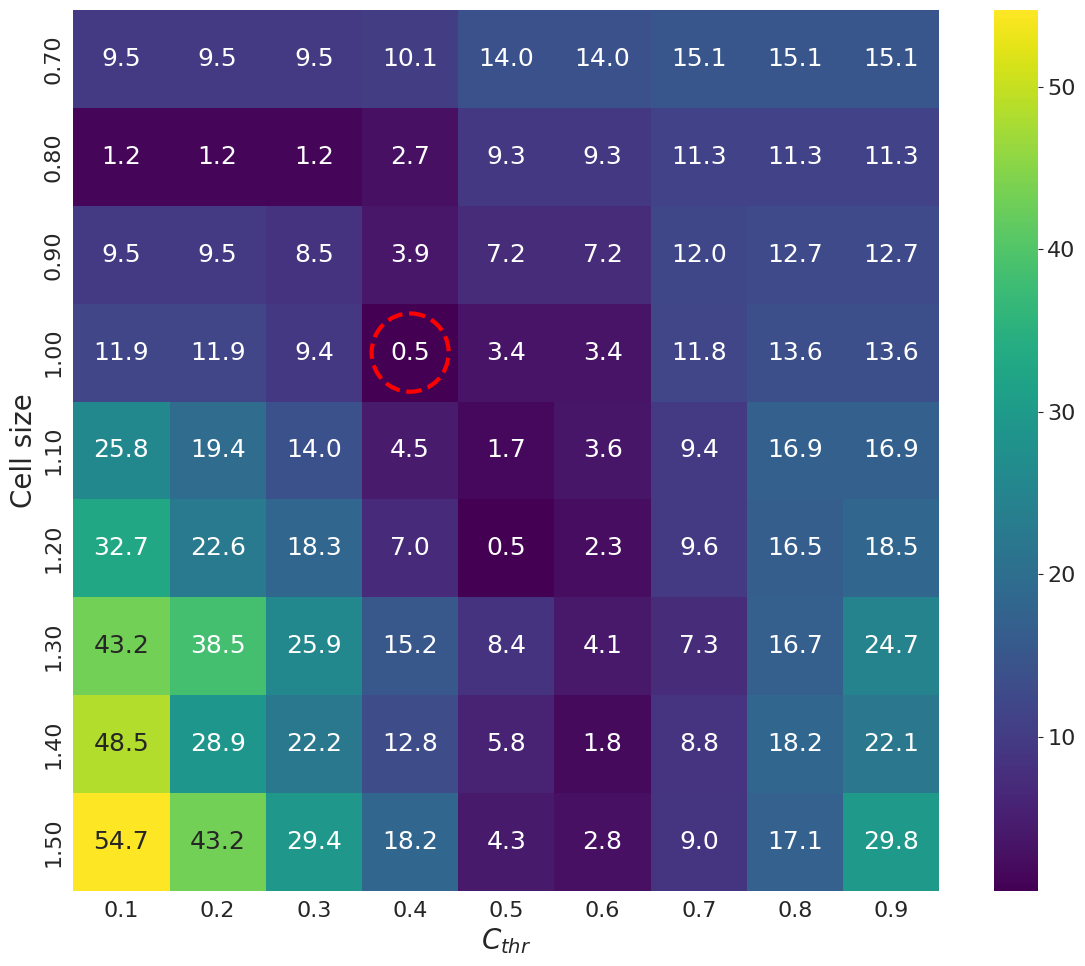

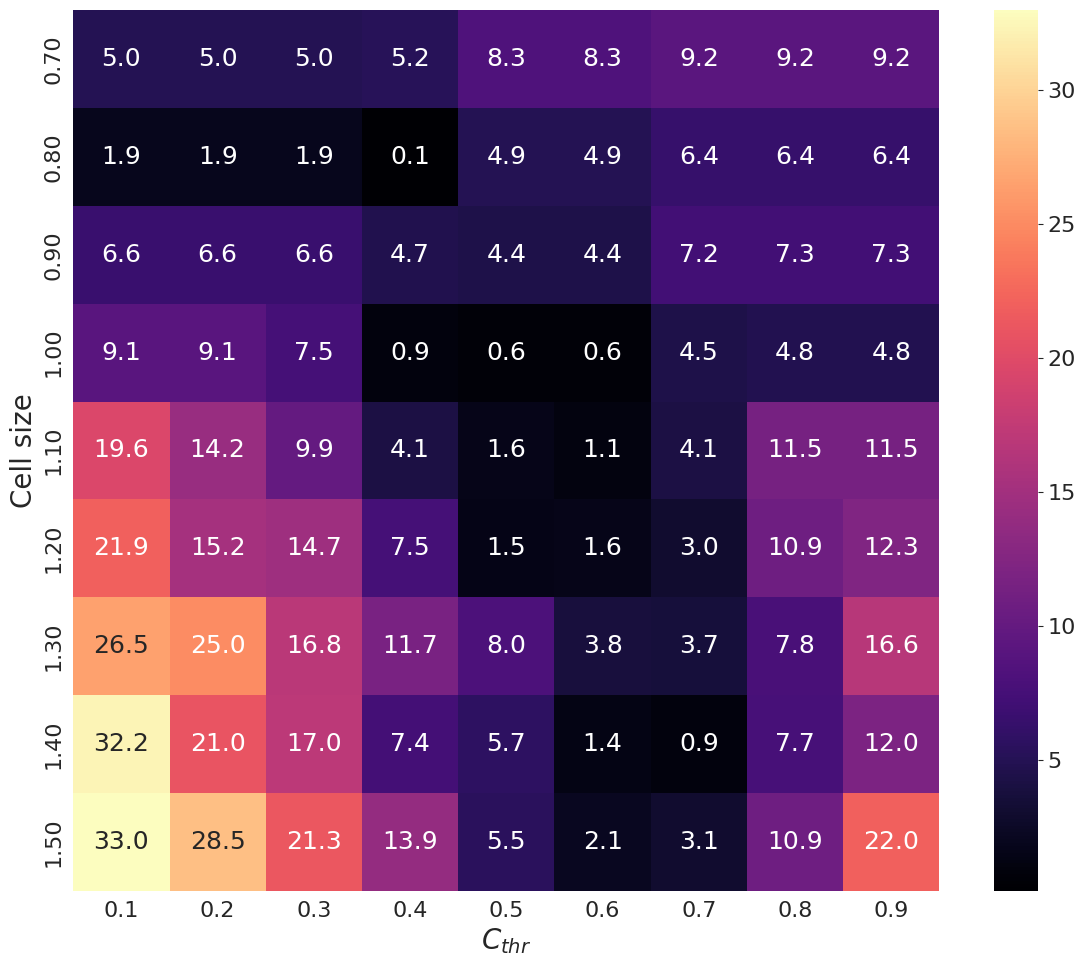

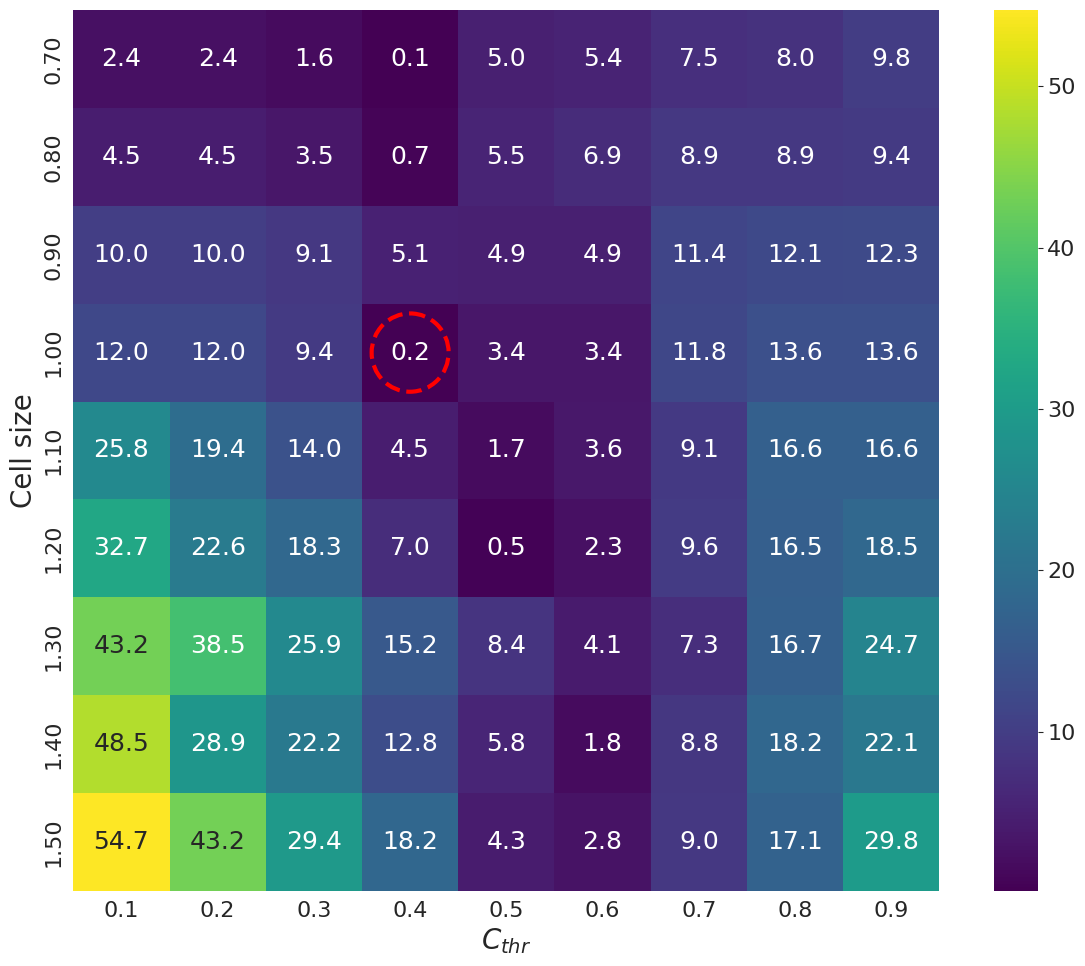

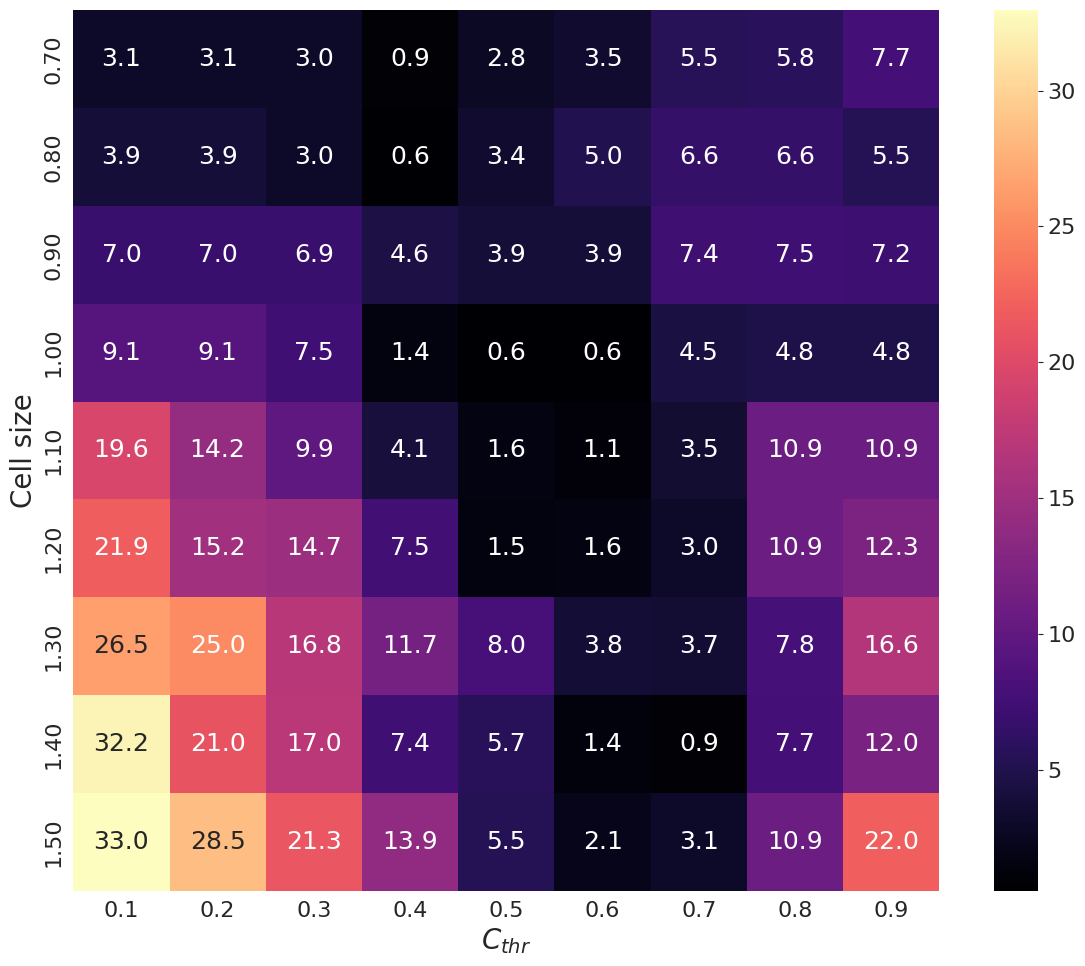

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# ================== Style ==================
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

DATA_DIR = "."
STEP = step   # reuse step from previous cell


# ====================================================
# Helper: build heatmaps from aggregated CSV
# ====================================================

def build_and_plot_heatmaps(mode: str):
    """
    mode: 'nodiff' or 'diff'
    Reads aggregated CSV produced in Cell 5
    """
    assert mode in ("nodiff", "diff")

    fname = f"grid_vs_atom_ALL_{mode}_step{STEP}.csv"
    path = os.path.join(DATA_DIR, fname)

    if not os.path.isfile(path):
        print(f"[Warning] File not found: {fname}")
        return

    df = pd.read_csv(path)

    # --- Use main nucleus only (cluster_id == 0) ---
    df = df[df["cluster_id"] == 0]
    if df.empty:
        print(f"[Warning] No cluster_id == 0 data for {mode}")
        return

    # Extract scalar cell size
    df["cell_size_scalar"] = df["cell_size"].apply(lambda x: eval(x)[0] if isinstance(x, str) else x[0])

    # Axes
    cell_sizes = sorted(df["cell_size_scalar"].unique())
    c_thrs = sorted(df["C_thr"].unique())

    # Matrices
    vol_matrix = np.full((len(cell_sizes), len(c_thrs)), np.nan)
    surf_matrix = np.full((len(cell_sizes), len(c_thrs)), np.nan)

    for i, cs in enumerate(cell_sizes):
        for j, ct in enumerate(c_thrs):
            sub = df[(df["cell_size_scalar"] == cs) & (df["C_thr"] == ct)]
            if not sub.empty:
                vol_matrix[i, j] = sub["volume_diff_pct"].mean()
                surf_matrix[i, j] = sub["surface_diff_pct"].mean()

    # ================= Volume heatmap =================
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        vol_matrix,
        xticklabels=[f"{ct:.1f}" for ct in c_thrs],
        yticklabels=[f"{cs:.2f}" for cs in cell_sizes],
        annot=True,
        fmt=".1f",
        cmap="viridis",
    )

    plt.xlabel(r"$C_{thr}$")
    plt.ylabel("Cell size")

    # Highlight reference point (1.0, 0.4)
    try:
        col = c_thrs.index(0.4)
        row = cell_sizes.index(1.0)
        circ = patches.Circle(
            (col + 0.5, row + 0.5),
            radius=0.4,
            edgecolor="red",
            facecolor="none",
            linewidth=3,
            linestyle="--",
        )
        ax.add_patch(circ)
    except ValueError:
        pass

    plt.tight_layout()
    plt.savefig(f"vol_diff_heatmap_{mode}_step{STEP}.png", dpi=300)
    plt.savefig(f"vol_diff_heatmap_{mode}_step{STEP}.pdf", dpi=300)
    plt.show()

    # ================= Surface heatmap =================
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        surf_matrix,
        xticklabels=[f"{ct:.1f}" for ct in c_thrs],
        yticklabels=[f"{cs:.2f}" for cs in cell_sizes],
        annot=True,
        fmt=".1f",
        cmap="magma",
    )

    plt.xlabel(r"$C_{thr}$")
    plt.ylabel("Cell size")

    plt.tight_layout()
    plt.savefig(f"surf_diff_heatmap_{mode}_step{STEP}.png", dpi=300)
    plt.savefig(f"surf_diff_heatmap_{mode}_step{STEP}.pdf", dpi=300)
    plt.show()


# ================= Run =================

build_and_plot_heatmaps("nodiff")
build_and_plot_heatmaps("diff")


In [25]:
### above was the diffusion imputation for cells with missing values (literal imputation task)
### to be added below, the diffsuion imputatoin for sparse cells nears (edge cells)